<CENTER>
    <a href="http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html" class="icons"><img src="https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/images/ATLASOD.gif?raw=1" style="width:40%"></a>
</CENTER>

# Searching for the Higgs boson in the H&#8594;&gamma;&gamma; channel

The Higgs boson can be created several different ways. We represent these different production mechanisms as Feynman diagrams that show particles interacting. Here are the four most important for the Standard Model Higgs boson:

<CENTER><img src="https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/images/Figures_FeynmanHprod.png?raw=1" style="width:30%"></CENTER>

Clockwise from the top right, those show two gluons creating a Higgs boson via a loop (the triangle; this diagram is also known as gluon-gluon fusion), the Higgs boson being radiated from a vector boson like a W or Z boson (this production mechanism comes with two forward quarks, which appear in the detector as "jets", and is known as vector-boson fusion), the Higgs boson being radiated from a top quark (the process is also known as "ttH" because of the two top quarks in the event), and the Higgs boson being radiated from a vector boson without the two additional quarks (in this case, the process is known as "associated production", because the Higgs boson is being made in association with a vector boson).

In this notebook, we will look for the Higgs boson decaying to two photons. The analysis is relatively straightforward: we look for exactly two photons in an event and ask that they are isolated. We then look at the invariant mass of the two photons to see if they might have originated from a Higgs boson. This analysis is similar to the [uproot-based Higgs$\rightarrow\gamma\gamma$ analysis](https://opendata.atlas.cern/docs/13TeV25Doc/StandardModel#higgs-to-%CE%B3%CE%B3-analysis-new).

## Implementation

We'll start by setting up the packages we need to work with the open data. In this case, we'll install `ROOT` (a standard analysis package used in particle physics) and `atlasopenmagic` (a package for working with the ATLAS open data). The setup is a big complicated so that it will work on either Binder or Colab:

* SWAN and Binder provide environments based on containers that include some of the software we want, while in Colab we need to install it.
* On Binder and SWAN we can use `%jsroot` magic to allow us to interact with the histograms that we draw (e.g. zoom).
* Binder doesn't allow us to use xrootd to access files, so we need to access them via the https protocol. Using the ROOT protocol will allow us to read files that are remote, rather than having to copy them locally before opening them.

You don't need to worry about the details above if you don't understand them, but those are the adjustments we'll make in the next cell.

We'll also start a timer, so that we can report how long it takes the notebook to run.

In [ ]:
# Our environment will depend on whether we're running in Colab, Binder, or SWAN
if 'google.colab' in str(get_ipython()):
    print('Running on Colab - will install ROOT')
    %pip install ROOT
    # Colab allows us to use the (easier) ROOT protocol to read files
    protocol = 'ROOT'
    import ROOT
    %jsroot off
else:
    print('Not running on Colab')
    # On Binder we have to use the https protocol to read files
    protocol = 'https'
    import ROOT
    # But on Binder we can enable jsroot, which lets us interact with the
    # histograms we draw later on
    %jsroot on
%pip install atlasopenmagic
# We'll also use the time module to report how long this notebook takes to run
import time
start = time.time()

Next, we'll use `atlasopenmagic` to get a file from the Open Data. If you'd like to understand what these lines do a bit better, you can go through the [metadata tutorial](https://opendata.atlas.cern/docs/13TeV25Doc/Concepts#accessing-metadata-new). Here we will also use the `GamGam` skim, which gives us files that contain events that all have at least two photons. After we have the file address, we'll open it using ROOT.

In [ ]:
# Use atlasopenmagic to get a file for us to look at
import atlasopenmagic as atom
atom.set_release('2025e-13tev-beta')
file_names = atom.get_urls('data',protocol=protocol,skim='GamGam',cache=False)

In the files, our data are kept in a tree called `analysis`. We will use a "chain" to loop over all the files and get the information from that tree. We can also ask the chain how main entries (events) it has. This can take a bit of time, as all the files have to be checked to calculate the total number of events, so it is not done by default.

In [ ]:
# Create a chain containing the analysis trees
chain = ROOT.TChain("analysis")
# Add all our input files to the chain
for file_name in file_names:
    chain.Add(file_name)
# If you wish, you can check how many events the chain contains
#chain.GetEntries()

Now we'll create a blank canvas on which we can draw the histogram, and we'll make an extra histogram that we can fill up with our data.

In [4]:
# Blank canvas
canvas = ROOT.TCanvas("Canvas","cz",800,600)
#Invariant mass histograms definition
hist = ROOT.TH1F("h_M_Hyy","Diphoton invariant-mass ; Invariant Mass m_{yy} [GeV] ; Events",55,105,160)

Now we'll loop over the events in our file (in the tree) and look for events that have exactly two photons. We'll check that those two photons are also isolated (they do not have lots of other particles around them), which is a good indication that they might have come from a Higgs boson decay. Once we have selected our two photons, we'll calculate their invariant mass, which we can plot in our histogram. If everything has gone well, we should see a small peak around the mass of the Higgs boson in our histogram.

In case you would like to see what variables are available in the Open Data files, you can read the [documentation here](https://opendata.atlas.cern/docs/data/for_education/13TeV25_details).

In [ ]:
# To save memory and go a little bit faster, we will make two Lorentz vectors
# here and re-use them during the loop over events
Photon_1 = ROOT.TLorentzVector()
Photon_2 = ROOT.TLorentzVector()

# To make this run a bit faster, we will disable any branches we don't need
chain.SetBranchStatus('*',0)
# Now let's enable exactly the branches we want
for variable in ['photon_pt', 'photon_eta', 'photon_phi',
                 'photon_isTightID', 'photon_ptcone20']:
    chain.SetBranchStatus(variable,1)

# In case you'd like to stop a bit earlier, before going through all the data,
# set this variable to a positive number
stop_early = 100000

# Now we'll loop through all the events, keeping the event number in mind
for n,event in enumerate(chain):
    # Check if we should stop
    if n>stop_early:
        break
    # Print the number of events we have processed so far
    if n%10000==0:
        print(f'Processing event {n}')

    # Check if our highest momentum photon passes basic momentum, isolation, and
    # location (pseudo-rapidity, or eta) requirements
    if chain.photon_isTightID[0]\
      and chain.photon_pt[0] > 50. and abs(chain.photon_eta[0]) < 2.37\
      and (abs(chain.photon_eta[0]) < 1.37 or abs(chain.photon_eta[0]) > 1.52)\
      and chain.photon_ptcone20[0]/chain.photon_pt[0]<0.055:
        # Good first photon! Let's see if our second photon also passes a
        # similar set of requirements We had a good photon!
        if chain.photon_isTightID[1]\
          and chain.photon_pt[1] > 30. and abs(chain.photon_eta[1]) < 2.37\
          and (abs(chain.photon_eta[1]) < 1.37 or abs(chain.photon_eta[1]) > 1.52)\
          and chain.photon_ptcone20[1]/chain.photon_pt[1]<0.055:
            # Good second phtoon!
            # Set the Lorentz vectors based on our photon kinematics.
            # We can take advantage of the fact that photons always have
            # zero mass to make the vector a bit simpler.
            Photon_1.SetPtEtaPhiM(chain.photon_pt[0],
                                  chain.photon_eta[0],
                                  chain.photon_phi[0],
                                  0)
            Photon_2.SetPtEtaPhiM(chain.photon_pt[1],
                                  chain.photon_eta[1],
                                  chain.photon_phi[1],
                                  0)
            # Add the two TLorentz vectors
            Photon_12 = Photon_1 + Photon_2
            # Finally, we'll require that the individual photon momentum is
            # at least 35% of the invariant mass. This requires some
            # symmetry, which is more common in Higgs boson decays than in
            # other Standard Model events.
            if chain.photon_pt[0]/Photon_12.M() > 0.35\
              and chain.photon_pt[1]/Photon_12.M() > 0.35:
                # Fill the histogram with the mass of the gamma-gamma system
                hist.Fill(Photon_12.M())
        # End of the isolation requirement
    # End of the check for 2-good photons
# End of the loop over the events

### Final plot
All we have to do now is draw our histogram on the canvas that we made, and then draw (display) the canvas. ROOT has lots of drawing options for histograms; you can read about them [here](https://root.cern.ch/doc/master/classTHistPainter.html).

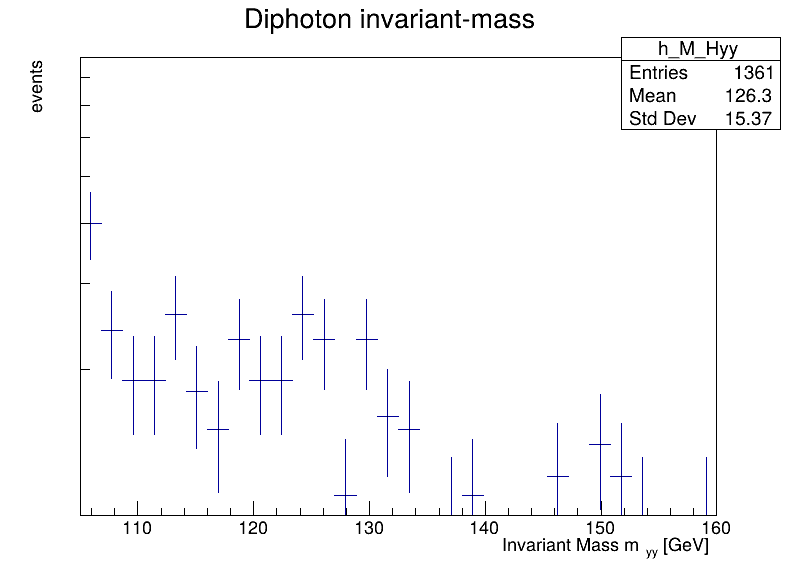

In [10]:
hist.Draw("E")
canvas.Draw()

Now that we're all done, we can report how much time this notebook took to run.

In [ ]:
end = time.time()
duration = end-start
print(f"Finished in {int(duration//60)} min {duration%60} s")

While our main task may be done, there's still more to explore! Here are some additional tasks you can try with this notebook:

* Check how many events are being thrown away by each cut the event loop above
* Add more cuts from the [Higgs boson discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0090) or the [Higgs decay to photons measurement paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.98.052005) in the event loop above
* Try adding a fit of the background and signal in the histogram above. You can try fitting the background with a fourth-degree polynominal and the signal with a Gaussian distribution
    * Find the mean of the fitted Gaussian — it should be close to the Higgs mass!
    * Find the width of the fitted Gaussian; what does it represent? Is it close to the expected width of the Higgs boson?
    * Try different functions for the fit - were those good choices?
* Try comparing the speed of this notebook to the [uproot-based version](https://opendata.atlas.cern/docs/13TeV25Doc/StandardModel#higgs-to-%CE%B3%CE%B3-analysis-new). Which one is faster? Can you find some simple ways to speed them up, or understand why one might be faster than the other?

<div class="alert alert-block alert-info">
We welcome your feedback on this notebook or any of our other materials! Please <a href="https://forms.gle/zKBqS1opAHHemv9U7">fill out this survey</a> to let us know how we're doing, and you can enter a raffle to win some <a href="https://atlas-secretariat.web.cern.ch/merchandise">ATLAS merchandise</a>!
</div>